In [ ]:
"""
Copyright Netherlands eScience Center
Function        : Compare AMET and OMET and NEMO ORCA0083 run
Author          : Yang Liu
Date            : 2018.05.23
Last Update     : 2018.06.04
Description     : The code aims to plot and compare the meridional energy transport
                  in both the atmosphere and ocean. The atmospheric meridional energy
                  transport is calculated from reanalysis data ERA-Interim, MERRA2 and
                  JRA55. The oceanic meridional energy transport is calculated from ORAS4,
                  GLORYS2V3, SODA3 and ORAS5.
Return Value    : NetCFD4 data file
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib, logging
variables       : Atmospheric Meridional Energy Transport   ERA-Interim     MERRA2       JRA55
                  Oceanic Meridional Energy Transport       ORAS4           GLORYS2V3    SODA3
Caveat!!        : Spatial and temporal coverage
                  Atmosphere
                  ERA-Interim   1979 - 2016
                  MERRA2        1980 - 2016
                  JRA55         1979 - 2015
                  Ocean
                  GLORYS2V3     1993 - 2014
                  ORAS4         1958 - 2014
                  SODA3         1980 - 2015
                  NEMO ORCA0083 1979 - 2012
                  The full dataset of ORAS4 is from 1958. However, a quality report from
                  Magdalena from ECMWF indicates the quality of data for the first
                  two decades are very poor. Hence we use the data from 1979. which
                  is the start of satellite era.
                  The full dataset of ORAS4 is from 1958.

                  Data from 20N - 90N are taken into account!
"""

In [2]:
import numpy as np
import seaborn as sns
#import scipy as sp
import time as tttt
from netCDF4 import Dataset,num2date
import os
import platform
import sys
import logging
import matplotlib
# generate images without having a window appear
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
#from scipy.interpolate import InterpolatedUnivariateSpline
import scipy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import iris
import iris.plot as iplt
import iris.quickplot as qplt

In [8]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [13]:
sns.set()
sns.set_style("ticks")
sns.despine()

################################   Input zone  ######################################
# specify data path
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
datapath_MERRA2 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/postprocessing'
datapath_JRA55 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/postprocessing'
# for the computation of residual AMET ERA-Interim
datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'

datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4/postprocessing'
datapath_GLORYS2V3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3/postprocessing'
datapath_SODA3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3/postprocessing'
datapath_NEMO = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORCA012_BenMoat/postprocessing'
# specify output path for the netCDF4 file
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/figures/revision'
################################   Input zone  ######################################
# ********************    latitude index of insteret     ********************* #
# There is a cut to JRA, too
# index of latitude for insteret
# 20N
lat_ERAI_20 = 93
lat_MERRA2_20 = 0
lat_JRA55_20 = 124

lat_ORAS4_20 = 181
lat_GLORYS2V3_20 = 579
lat_SODA3_20 = 569
lat_NEMO_20 = 245
# after a cut to 20-90 N
lat_ORAS4_20_cut = 1
lat_GLORYS2V3_20_cut = 0
lat_SODA3_20_cut = 0
lat_NEMO_20_cut = 0

# 30N
lat_ERAI_30 = 80
lat_MERRA2_30 = 20
lat_JRA55_30 = 106

lat_ORAS4_30 = 192
lat_GLORYS2V3_30 = 623
lat_SODA3_30 = 613
lat_NEMO_30 = 377
# after a cut to 20-90 N
lat_ORAS4_30_cut = 12
lat_GLORYS2V3_30_cut = 44
lat_SODA3_30_cut = 44
lat_NEMO_30_cut = 132

# 40N
lat_ERAI_40 = 67
lat_MERRA2_40 = 40
lat_JRA55_40 = 88

lat_ORAS4_40 = 204
lat_GLORYS2V3_40 = 672
lat_SODA3_40 = 662
lat_NEMO_40 = 522
# after a cut to 20-90 N
lat_ORAS4_40_cut = 24
lat_GLORYS2V3_40_cut = 93
lat_SODA3_40_cut = 93
lat_NEMO_40_cut = 277

# 50N
lat_ERAI_50 = 53
lat_MERRA2_50 = 60
lat_JRA55_50 = 70

lat_ORAS4_50 = 218
lat_GLORYS2V3_50 = 726
lat_SODA3_50 = 719
lat_NEMO_50 = 685
# after a cut to 20-90 N
lat_ORAS4_50_cut = 38
lat_GLORYS2V3_50_cut = 147
lat_SODA3_50_cut = 150
lat_NEMO_50_cut = 440

# 60N
lat_ERAI_60 = 40
lat_MERRA2_60 = 80
lat_JRA55_60 = 53

lat_ORAS4_60 = 233
lat_GLORYS2V3_60 = 788
lat_SODA3_60 = 789
lat_NEMO_60 = 871
# after a cut to 20-90 N
lat_ORAS4_60_cut = 53
lat_GLORYS2V3_60_cut = 209
lat_SODA3_60_cut = 220
lat_NEMO_60_cut = 626

# 70N
lat_ERAI_70 = 27
lat_MERRA2_70 = 100
lat_JRA55_70 = 35

lat_ORAS4_70 = 250
lat_GLORYS2V3_70 = 857
lat_SODA3_70 = 880
lat_NEMO_70 = 1078
# after a cut to 20-90 N
lat_ORAS4_70_cut = 70
lat_GLORYS2V3_70_cut = 278
lat_SODA3_70_cut = 311
lat_NEMO_70_cut = 833

# 80N
lat_ERAI_80 = 13
lat_MERRA2_80 = 120
lat_JRA55_80 = 17

lat_ORAS4_80 = 269
lat_GLORYS2V3_80 = 932
lat_SODA3_80 = 974
lat_NEMO_80 = 1303
# after a cut to 20-90 N
lat_ORAS4_80_cut = 89
lat_GLORYS2V3_80_cut = 353
lat_SODA3_80_cut = 405
lat_NEMO_80_cut = 1058

# make a dictionary for instereted sections (for process automation)
lat_interest = {}
lat_interest_list = [20,30,40,50,60,70,80]
lat_interest['ERAI'] = [lat_ERAI_20,lat_ERAI_30,lat_ERAI_40,lat_ERAI_50,lat_ERAI_60,lat_ERAI_70,lat_ERAI_80]
lat_interest['MERRA2'] = [lat_MERRA2_20,lat_MERRA2_30,lat_MERRA2_40,lat_MERRA2_50,lat_MERRA2_60,lat_MERRA2_70,lat_MERRA2_80]
lat_interest['JRA55'] = [lat_JRA55_20,lat_JRA55_30,lat_JRA55_40,lat_JRA55_50,lat_JRA55_60,lat_JRA55_70,lat_JRA55_80]
# after cut
lat_interest['ORAS4'] = [lat_ORAS4_20_cut,lat_ORAS4_30_cut,lat_ORAS4_40_cut,lat_ORAS4_50_cut,lat_ORAS4_60_cut,lat_ORAS4_70_cut,lat_ORAS4_80_cut]
lat_interest['GLORYS2V3'] = [lat_GLORYS2V3_20_cut,lat_GLORYS2V3_30_cut,lat_GLORYS2V3_40_cut,lat_GLORYS2V3_50_cut,lat_GLORYS2V3_60_cut,lat_GLORYS2V3_70_cut,lat_GLORYS2V3_80_cut]
lat_interest['SODA3'] = [lat_SODA3_20_cut,lat_SODA3_30_cut,lat_SODA3_40_cut,lat_SODA3_50_cut,lat_SODA3_60_cut,lat_SODA3_70_cut,lat_SODA3_80_cut]
lat_interest['NEMO'] = [lat_NEMO_20_cut,lat_NEMO_30_cut,lat_NEMO_40_cut,lat_NEMO_50_cut,lat_NEMO_60_cut,lat_NEMO_70_cut,lat_NEMO_80_cut]

<Figure size 432x288 with 0 Axes>

In [10]:
# *********************** extract variables ************************* #
# # ORCA1_z42 grid infor (Madec and Imbard 1996)
# ji_1 = 362
# jj_1 = 292
# level_1 = 42
#
# # ORCA025_z75 grid infor (Madec and Imbard 1996)
# ji_025 = 1440
# jj_025 = 1021
# level_025 = 75

# # MOM5_z50 grid info
# ji_5 = 1440
# jj_5 = 1070
# level_5 = 50

# # ORCA083_z75 grid infor
# ji_12 = 4322
# jj_12 = 1565
# level = 75

dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                   'surface_erai_monthly_regress_1979_2017_radiation.nc'))
dataset_ERAI = Dataset(datapath_ERAI + os.sep + 'model_daily_075_1979_2016_E_zonal_int.nc')
dataset_MERRA2 = Dataset(datapath_MERRA2 + os.sep + 'AMET_MERRA2_model_daily_1980_2016_E_zonal_int.nc')
dataset_JRA55 = Dataset(datapath_JRA55 + os.sep + 'AMET_JRA55_model_daily_1979_2015_E_zonal_int.nc')

dataset_GLORYS2V3 = Dataset(datapath_GLORYS2V3 + os.sep + 'GLORYS2V3_model_monthly_orca025_E_zonal_int.nc')
dataset_ORAS4 = Dataset(datapath_ORAS4 + os.sep + 'oras4_model_monthly_orca1_E_zonal_int.nc')
dataset_SODA3 = Dataset(datapath_SODA3 + os.sep + 'OMET_SODA3_model_5daily_1980_2015_E_zonal_int.nc')
dataset_NEMO =Dataset(datapath_NEMO + os.sep + 'OMET_NEMO_ORCA0083_daily_1979_2012_E_zonal_int.nc')
#dataset_AMET_point = Dataset(datapath_AMET + os.sep + 'model_daily_075_1979_2016_E_point.nc')
#dataset_OMET_point = Dataset(datapath_OMET + os.sep + 'oras4_model_monthly_orca1_1958_2014_E_point.nc')

# from 1979 to 2014
# from 20N - 90N
AMET_ERAI = dataset_ERAI.variables['E'][:]/1000 # from Tera Watt to Peta Watt
AMET_MERRA2 = dataset_MERRA2.variables['E'][:]/1000 # from Tera Watt to Peta Watt
AMET_JRA55 = dataset_JRA55.variables['E'][:,:,0:125]/1000 # from Tera Watt to Peta Watt

OMET_ORAS4 = dataset_ORAS4.variables['E'][21:,:,180:]/1000 # start from 1979
OMET_GLORYS2V3 = dataset_GLORYS2V3.variables['E'][:,:,579:]/1000 # start from 1993
OMET_SODA3 = dataset_SODA3.variables['E'][:,:,569:]/1000 # start from 1980
OMET_NEMO = dataset_NEMO.variables['E'][:,:,245:]/1000 # start from 1979

# extract time series from 1979 to 2016
# from 20N - 90N
# 4D fields [year, month, lat, lon]
rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:-1,:,:,:]
rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:-1,:,:,:]
rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:-1,:,:,:]
rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:-1,:,:,:]
SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:-1,:,:,:]
SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:-1,:,:,:]
# calculate total net energy flux at TOA/surface
net_flux_surf_ERAI = rad_short_surf_ERAI + rad_long_surf_ERAI + SFlux_sensible_ERAI + SFlux_latent_ERAI
net_flux_toa_ERAI = rad_short_toa_ERAI + rad_long_toa_ERAI

year_ERAI = dataset_ERAI.variables['year'][:]             # from 1979 to 2014
year_MERRA2 = dataset_MERRA2.variables['year'][:]         # from 1980 to 2014
year_JRA55 = dataset_JRA55.variables['year'][:]           # from 1979 to 2015

year_ORAS4 = dataset_ORAS4.variables['year'][21:]         # from 1979 to 2014
year_GLORYS2V3 = dataset_GLORYS2V3.variables['year'][:]   # from 1993 to 2014
year_SODA3 = dataset_SODA3.variables['year'][:]           # from 1980 to 2014
year_NEMO = dataset_NEMO.variables['year'][:]           # from 1980 to 2014

latitude_ERAI = dataset_ERAI.variables['latitude'][:]
latitude_MERRA2 = dataset_MERRA2.variables['latitude'][:]
latitude_JRA55 = dataset_JRA55.variables['latitude'][0:125]

latitude_ORAS4 = dataset_ORAS4.variables['latitude_aux'][180:]
latitude_GLORYS2V3 = dataset_GLORYS2V3.variables['latitude_aux'][579:]
latitude_SODA3 = dataset_SODA3.variables['latitude_aux'][569:]
latitude_NEMO = dataset_NEMO.variables['latitude_aux'][245:]

latitude_fields_ERAI = dataset_ERAI_fields_flux.variables['latitude'][:]
longitude_fields_ERAI = dataset_ERAI_fields_flux.variables['longitude'][:]

# area weighted surface flux
net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float) # unit W
net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
#size of the grid box
dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                        360) / len(longitude_fields_ERAI)
dy = np.pi * constant['R'] / len(latitude_fields_ERAI)
for i in np.arange(len(latitude_fields_ERAI)):
    # change the unit to terawatt
    net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:]* dx[i] * dy / 1E+12
    net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:]* dx[i] * dy / 1E+12

In [11]:
print ('Compute AMET as the residuals of net flux at TOA & surface.')
# take the zonal mean of flux
net_flux_surf_ERAI_int = np.sum(net_flux_surf_ERAI_area,3) / 1000 # PW
net_flux_toa_ERAI_int = np.sum(net_flux_toa_ERAI_area,3) / 1000
# AMET as the residual of net flux at TOA & surface
AMET_res_ERAI = np.zeros(net_flux_surf_ERAI_int.shape)
for i in np.arange(len(latitude_fields_ERAI)-1):
    AMET_res_ERAI[:,:,i] = -(np.sum(net_flux_toa_ERAI_int[:,:,0:i+1],2) -
                             np.sum(net_flux_surf_ERAI_int[:,:,0:i+1],2))
print (AMET_res_ERAI.shape)

Compute AMET as the residuals of net flux at TOA & surface.
(38, 12, 241)


In [23]:
# *************************** whitening ***************************** #
month_ind = np.arange(12)
seansonal_cycle_AMET_ERAI = np.mean(AMET_ERAI,axis=0)
seansonal_cycle_AMET_MERRA2 = np.mean(AMET_MERRA2,axis=0)
seansonal_cycle_AMET_JRA55 = np.mean(AMET_JRA55,axis=0)

seansonal_cycle_AMET_res_ERAI = np.mean(AMET_res_ERAI,axis=0)

seansonal_cycle_OMET_ORAS4 = np.mean(OMET_ORAS4,axis=0)
seansonal_cycle_OMET_GLORYS2V3 = np.mean(OMET_GLORYS2V3,axis=0)
seansonal_cycle_OMET_SODA3 = np.mean(OMET_SODA3,axis=0)
seansonal_cycle_OMET_NEMO = np.mean(OMET_NEMO,axis=0)

AMET_ERAI_white = np.zeros(AMET_ERAI.shape,dtype=float)
AMET_MERRA2_white = np.zeros(AMET_MERRA2.shape,dtype=float)
AMET_JRA55_white = np.zeros(AMET_JRA55.shape,dtype=float)

AMET_res_ERAI_white = np.zeros(AMET_res_ERAI.shape,dtype=float)

OMET_ORAS4_white = np.zeros(OMET_ORAS4.shape,dtype=float)
OMET_GLORYS2V3_white = np.zeros(OMET_GLORYS2V3.shape,dtype=float)
OMET_SODA3_white = np.zeros(OMET_SODA3.shape,dtype=float)
OMET_NEMO_white = np.zeros(OMET_NEMO.shape,dtype=float)

for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_ERAI_white[i,j,:] = AMET_ERAI[i,j,:] - seansonal_cycle_AMET_ERAI[j,:]

for i in np.arange(len(year_MERRA2)):
    for j in month_ind:
        AMET_MERRA2_white[i,j,:] = AMET_MERRA2[i,j,:] - seansonal_cycle_AMET_MERRA2[j,:]

for i in np.arange(len(year_JRA55)):
    for j in month_ind:
        AMET_JRA55_white[i,j,:] = AMET_JRA55[i,j,:] - seansonal_cycle_AMET_JRA55[j,:]

for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_res_ERAI_white[i,j,:] = AMET_res_ERAI[i,j,:] - seansonal_cycle_AMET_res_ERAI[j,:]
        
for i in np.arange(len(year_ORAS4)):
    for j in month_ind:
        OMET_ORAS4_white[i,j,:] = OMET_ORAS4[i,j,:] - seansonal_cycle_OMET_ORAS4[j,:]

for i in np.arange(len(year_GLORYS2V3)):
    for j in month_ind:
        OMET_GLORYS2V3_white[i,j,:] = OMET_GLORYS2V3[i,j,:] - seansonal_cycle_OMET_GLORYS2V3[j,:]

for i in np.arange(len(year_SODA3)):
    for j in month_ind:
        OMET_SODA3_white[i,j,:] = OMET_SODA3[i,j,:] - seansonal_cycle_OMET_SODA3[j,:]

for i in np.arange(len(year_NEMO)):
    for j in month_ind:
        OMET_NEMO_white[i,j,:] = OMET_NEMO[i,j,:] - seansonal_cycle_OMET_NEMO[j,:]

# ****************** prepare variables for plot ********************* #
# annual mean of AMET and OMET at different latitudes
AMET_ERAI_mean = np.mean(np.mean(AMET_ERAI,0),0)
AMET_MERRA2_mean = np.mean(np.mean(AMET_MERRA2,0),0)
AMET_JRA55_mean = np.mean(np.mean(AMET_JRA55,0),0)

AMET_res_ERAI_mean = np.mean(np.mean(AMET_res_ERAI,0),0)

OMET_ORAS4_mean = np.mean(np.mean(OMET_ORAS4,0),0)
OMET_GLORYS2V3_mean = np.mean(np.mean(OMET_GLORYS2V3,0),0)
OMET_SODA3_mean = np.mean(np.mean(OMET_SODA3,0),0)
OMET_NEMO_mean = np.mean(np.mean(OMET_NEMO,0),0)
# dataset with seasonal cycle - time series
AMET_ERAI_series = AMET_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_MERRA2_series = AMET_MERRA2.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_JRA55_series = AMET_JRA55.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))

AMET_res_ERAI_series = AMET_res_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_fields_ERAI))

OMET_ORAS4_series = OMET_ORAS4.reshape(len(year_ORAS4)*len(month_ind),len(latitude_ORAS4))
OMET_GLORYS2V3_series = OMET_GLORYS2V3.reshape(len(year_GLORYS2V3)*len(month_ind),len(latitude_GLORYS2V3))
OMET_SODA3_series = OMET_SODA3.reshape(len(year_SODA3)*len(month_ind),len(latitude_SODA3))
OMET_NEMO_series = OMET_NEMO.reshape(len(year_NEMO)*len(month_ind),len(latitude_NEMO))

# dataset without seasonal cycle - time series
AMET_ERAI_white_series = AMET_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_MERRA2_white_series = AMET_MERRA2_white.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_JRA55_white_series = AMET_JRA55_white.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))

AMET_res_ERAI_white_series = AMET_res_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_fields_ERAI))

OMET_ORAS4_white_series = OMET_ORAS4_white.reshape(len(year_ORAS4)*len(month_ind),len(latitude_ORAS4))
OMET_GLORYS2V3_white_series = OMET_GLORYS2V3_white.reshape(len(year_GLORYS2V3)*len(month_ind),len(latitude_GLORYS2V3))
OMET_SODA3_white_series = OMET_SODA3_white.reshape(len(year_SODA3)*len(month_ind),len(latitude_SODA3))
OMET_NEMO_white_series = OMET_NEMO_white.reshape(len(year_NEMO)*len(month_ind),len(latitude_NEMO))
# ***************   standard deviation at each lat   **************** #
# standard deviation at each latitude
# for error bar band
# reshape of each dataset at full latitude for the calculation of standard deviation
AMET_ERAI_std = np.std(AMET_ERAI_series,axis=0)
AMET_ERAI_error_plus = AMET_ERAI_mean + AMET_ERAI_std
AMET_ERAI_error_minus = AMET_ERAI_mean - AMET_ERAI_std

AMET_MERRA2_std = np.std(AMET_MERRA2_series,axis=0)
AMET_MERRA2_error_plus = AMET_MERRA2_mean + AMET_MERRA2_std
AMET_MERRA2_error_minus = AMET_MERRA2_mean - AMET_MERRA2_std

AMET_JRA55_std = np.std(AMET_JRA55_series,axis=0)
AMET_JRA55_error_plus = AMET_JRA55_mean + AMET_JRA55_std
AMET_JRA55_error_minus = AMET_JRA55_mean - AMET_JRA55_std

AMET_res_ERAI_std = np.std(AMET_res_ERAI_series,axis=0)
AMET_res_ERAI_error_plus = AMET_res_ERAI_mean + AMET_res_ERAI_std
AMET_res_ERAI_error_minus = AMET_res_ERAI_mean - AMET_res_ERAI_std

OMET_ORAS4_std = np.std(OMET_ORAS4_series,axis=0)
OMET_ORAS4_error_plus = OMET_ORAS4_mean + OMET_ORAS4_std
OMET_ORAS4_error_minus = OMET_ORAS4_mean - OMET_ORAS4_std

OMET_GLORYS2V3_std = np.std(OMET_GLORYS2V3_series,axis=0)
OMET_GLORYS2V3_error_plus = OMET_GLORYS2V3_mean + OMET_GLORYS2V3_std
OMET_GLORYS2V3_error_minus = OMET_GLORYS2V3_mean - OMET_GLORYS2V3_std

OMET_SODA3_std = np.std(OMET_SODA3_series,axis=0)
OMET_SODA3_error_plus = OMET_SODA3_mean + OMET_SODA3_std
OMET_SODA3_error_minus = OMET_SODA3_mean - OMET_SODA3_std

OMET_NEMO_std = np.std(OMET_NEMO_series,axis=0)
OMET_NEMO_error_plus = OMET_NEMO_mean + OMET_NEMO_std
OMET_NEMO_error_minus = OMET_NEMO_mean - OMET_NEMO_std
# ***************   span of annual mean at each lat   *************** #
# calculate annual mean
AMET_ERAI_full_annual_mean = np.mean(AMET_ERAI,1)
AMET_MERRA2_full_annual_mean = np.mean(AMET_MERRA2,1)
AMET_JRA55_full_annual_mean = np.mean(AMET_JRA55,1)
AMET_res_ERAI_full_annual_mean = np.mean(AMET_res_ERAI,1)
OMET_ORAS4_full_annual_mean = np.mean(OMET_ORAS4,1)
OMET_GLORYS2V3_full_annual_mean = np.mean(OMET_GLORYS2V3,1)
OMET_SODA3_full_annual_mean = np.mean(OMET_SODA3,1)
OMET_NEMO_full_annual_mean = np.mean(OMET_NEMO,1)
# calculate the difference between annual mean and mean of entire time series
AMET_ERAI_full_annual_mean_max = np.amax(AMET_ERAI_full_annual_mean,0)
AMET_MERRA2_full_annual_mean_max = np.amax(AMET_MERRA2_full_annual_mean,0)
AMET_JRA55_full_annual_mean_max = np.amax(AMET_JRA55_full_annual_mean,0)
AMET_res_ERAI_full_annual_mean_max = np.amax(AMET_res_ERAI_full_annual_mean,0)
OMET_ORAS4_full_annual_mean_max = np.amax(OMET_ORAS4_full_annual_mean,0)
OMET_GLORYS2V3_full_annual_mean_max = np.amax(OMET_GLORYS2V3_full_annual_mean,0)
OMET_SODA3_full_annual_mean_max = np.amax(OMET_SODA3_full_annual_mean,0)
OMET_NEMO_full_annual_mean_max = np.amax(OMET_NEMO_full_annual_mean,0)

AMET_ERAI_full_annual_mean_min = np.amin(AMET_ERAI_full_annual_mean,0)
AMET_MERRA2_full_annual_mean_min = np.amin(AMET_MERRA2_full_annual_mean,0)
AMET_JRA55_full_annual_mean_min = np.amin(AMET_JRA55_full_annual_mean,0)
AMET_res_ERAI_full_annual_mean_min = np.amin(AMET_res_ERAI_full_annual_mean,0)
OMET_ORAS4_full_annual_mean_min = np.amin(OMET_ORAS4_full_annual_mean,0)
OMET_GLORYS2V3_full_annual_mean_min = np.amin(OMET_GLORYS2V3_full_annual_mean,0)
OMET_SODA3_full_annual_mean_min = np.amin(OMET_SODA3_full_annual_mean,0)
OMET_NEMO_full_annual_mean_min = np.amin(OMET_NEMO_full_annual_mean,0)

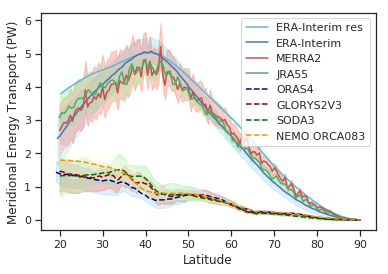

In [28]:
# *************************** x-y plots ***************************** #
fig00 = plt.figure()
plt.plot(latitude_fields_ERAI[:94],AMET_res_ERAI_mean[:94],'c-',label='ERA-Interim res')
plt.fill_between(latitude_fields_ERAI[:94],AMET_res_ERAI_full_annual_mean_max[:94],AMET_res_ERAI_full_annual_mean_min[:94],alpha=0.4,edgecolor='lightcyan', facecolor='lightcyan')
plt.plot(latitude_ERAI,AMET_ERAI_mean,'b-',label='ERA-Interim')
plt.fill_between(latitude_ERAI,AMET_ERAI_full_annual_mean_max,AMET_ERAI_full_annual_mean_min,alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
plt.plot(latitude_MERRA2,AMET_MERRA2_mean,'r-',label='MERRA2')
plt.fill_between(latitude_MERRA2,AMET_MERRA2_full_annual_mean_max,AMET_MERRA2_full_annual_mean_min,alpha=0.3,edgecolor='tomato', facecolor='tomato')
plt.plot(latitude_JRA55,AMET_JRA55_mean,'g-',label='JRA55')
plt.fill_between(latitude_JRA55,AMET_JRA55_full_annual_mean_max,AMET_JRA55_full_annual_mean_min,alpha=0.3,edgecolor='lightgreen', facecolor='lightgreen')
plt.plot(latitude_ORAS4,OMET_ORAS4_mean,color='darkblue',linestyle='--',label='ORAS4')
plt.fill_between(latitude_ORAS4,OMET_ORAS4_full_annual_mean_max,OMET_ORAS4_full_annual_mean_min,alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
plt.plot(latitude_GLORYS2V3,OMET_GLORYS2V3_mean,color='darkred',linestyle='--',label='GLORYS2V3')
plt.fill_between(latitude_GLORYS2V3,OMET_GLORYS2V3_full_annual_mean_max,OMET_GLORYS2V3_full_annual_mean_min,alpha=0.3,edgecolor='tomato', facecolor='tomato')
plt.plot(latitude_SODA3,OMET_SODA3_mean,color='darkgreen',linestyle='--',label='SODA3')
plt.fill_between(latitude_SODA3,OMET_SODA3_full_annual_mean_max,OMET_SODA3_full_annual_mean_min,alpha=0.3,edgecolor='lightgreen', facecolor='lightgreen')
plt.plot(latitude_NEMO,OMET_NEMO_mean,color='darkorange',linestyle='--',label='NEMO ORCA083')
plt.fill_between(latitude_NEMO,OMET_NEMO_full_annual_mean_max,OMET_NEMO_full_annual_mean_min,alpha=0.3,edgecolor='lightyellow', facecolor='lightyellow')
#plt.plot(latitude_AMET,AMET_mean + OMET_mean_interpolate,'g--',label='Total')
#plt.title('Mean AMET & OMET of entire time series from 20N to 90N')
plt.legend()
#fig1.set_size_inches(5, 5)
plt.xlabel("Latitude")
labels =['20','30','40','50','60','70','80','90']
plt.xticks(np.linspace(20, 90, 8),labels)
#plt.xticks(rotation=60)
plt.ylabel("Meridional Energy Transport (PW)")
plt.show()
fig00.savefig(output_path + os.sep + 'AMET_OMET_NEMO_annual_mean_span.jpg', dpi = 500)
